## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

# 1. Подготовка

In [1]:
import sys
import time
import datetime
from pprint import pprint

import numpy as np
import pandas as pd

# import scipy as sc
# import sklearn
# from scipy import stats as st
# import statsmodels.stats.api as sms

# pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight')

import warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')


In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
# from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor


/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/opt/conda/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
from IPython.display import Markdown, display, display_html, HTML

def printmd(string, color=None):
    if color != None:
        string = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(string))    

def print_bold(string, color=None):
    printmd("**{}**".format(string), color)

def print_header(string):
    printmd("### {}".format(string))

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline;margin-right: 10px;"'),raw=True)

def print_df(df):
    display_side_by_side(df)
    
# printmd('__bold__')
# print_bold('bold')
# print_header('print_header')

In [4]:
def print_now():
    print(datetime.datetime.now())
    
# print_now()

In [5]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)


In [6]:
print('Индекс монолитен' if data.index.is_monotonic else 'Индекс не монолитен')

Индекс монолитен


In [7]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [8]:
data.shape

(26496, 1)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [10]:
data.isna().sum()

num_orders    0
dtype: int64

In [11]:
data.index.duplicated().sum()

0

## Выводы

* Индекс монолитен
* Кол-во строк 26496
* Дубликатов нет
* Пропусков нет
* Данные в диапазоне от 2018-03-01 00:00:00 до 2018-08-31 23:00:00

# 2. Анализ

In [12]:
# Гистгорама и Диаграмма размаха
def data_explore(data_df, col, title, whis=1.5):
    query = data_df[[col]]
    query.plot(kind='hist', title=title)
    plt.show()
    # query.boxplot(whis=2, figsize=(8,6))
    query.boxplot(whis=1.5)
    plt.show()


In [13]:
data_1H = data.resample('1H').sum()
print('Записей после ресемплированию по часу: {}'.format(
    data_1H.shape[0]
))

Записей после ресемплированию по часу: 4416


In [14]:
data_1H.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [15]:
data_1H.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


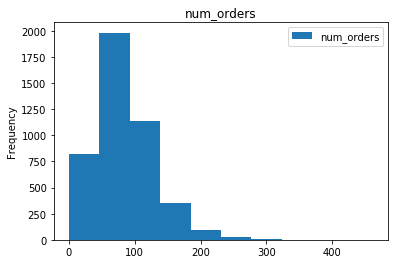

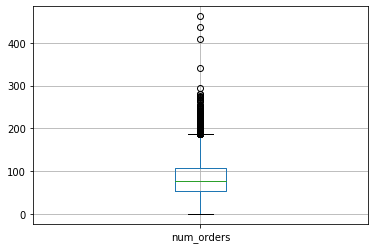

In [16]:
data_explore(data_1H, 'num_orders', 'num_orders', whis=3)

Есть что-то похожее на выбросы в значениях >200

In [17]:
print('Кол-во заказов>200: {}'.format(
    data_1H.query('num_orders>200').shape[0])
)

print('Кол-во заказов>200 в августе: {}'.format(
    data_1H['2018-08'].query('num_orders>200').shape[0])
)

Кол-во заказов>200: 81
Кол-во заказов>200 в августе: 68


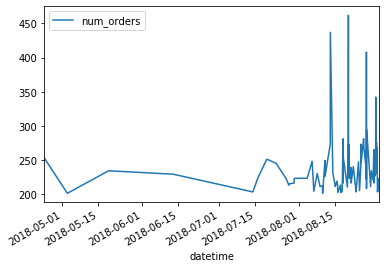

In [18]:
data_1H.query('num_orders>200').plot()

Часы с большим кол-вом заказов в основном после 15 августа.

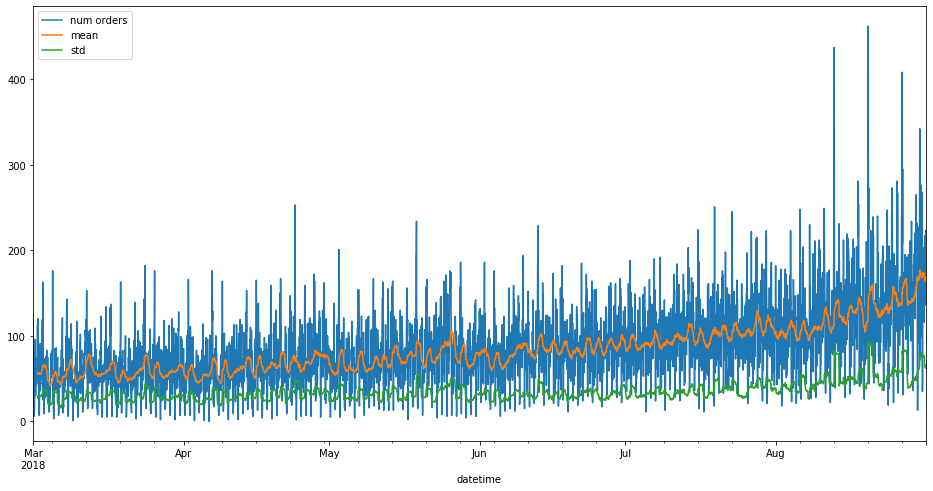

In [19]:
fig, ax = plt.subplots(figsize=(16, 8))
opt = {'ax':ax, 'kind':'line'}

df = data_1H
df.plot(**opt)
df.rolling(24).mean().plot(**opt)
df.rolling(24).std().plot(**opt)
ax.legend(['num orders', 'mean', 'std']);

Мне хотелось что-нибудь увидеть на графике используя окно, но я ничего не увидел. =)

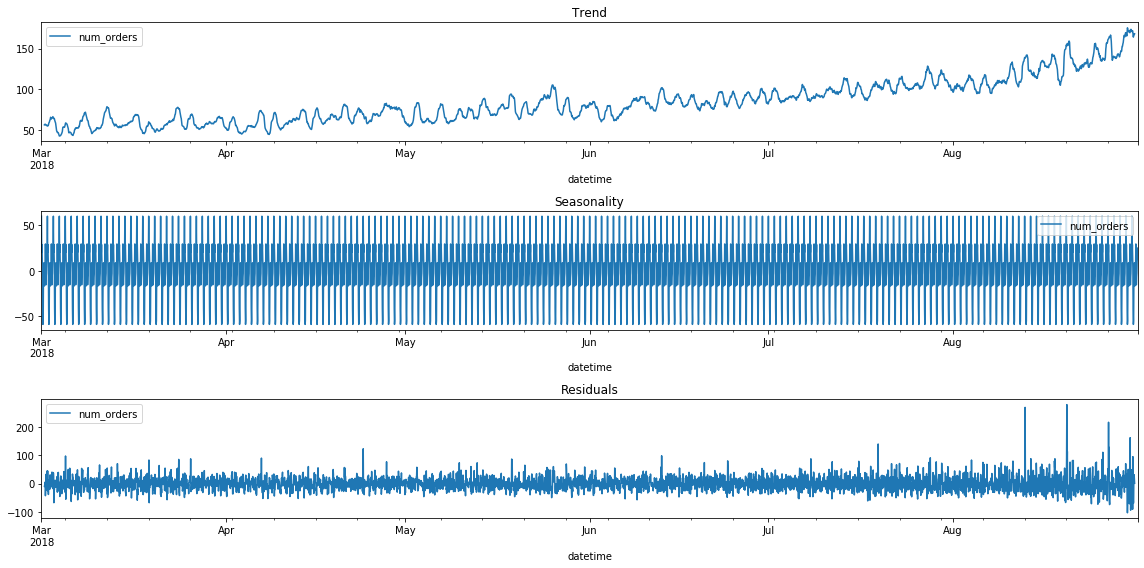

In [20]:
decomposed = seasonal_decompose(data_1H)

plt.figure(figsize=(16, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()



Видно сезонность внутри дня и восходящий тренд в августе.

## Выводы

Данные ресемплированные по 1 часу

Записей после ресемплирования по часу: 4416

Делал скользящее среднее и дисперсию по 24 часа. Ничего не могу сказать о данных по графику?
 
Графики тренды и сезонность. По тренду видно увеличение заказов в августе. Выглядит график нормально. Можно предположить что это связано с концом летнего сезона. Но я больше склоняюсь к тому что это связано с удачным маркетингом. Либо развитием проекта в целом. Для потвержения гипотезы о летнем сезоне, я не вижу спада в мае-июне.

Пробовал увидеть "сезонность" по дням недели. Не смог придумать визуализацию.

Есть "сезонность" внутри суток ночью заказов сильно меньше чем днем.

При построении модели нужно учесть
* Мы прогнозируем кол-во поездок для часа
* Внутри суток есть "сезонность"

# 3. Обучение

In [21]:
def make_features(df, max_lag, rolling_mean_size, hour=False):
    # df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    if hour:
        df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df


In [22]:
def rmse_scorer(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    print('RMSE: {}'.format(rmse))
    return rmse
# rmse_scorer(y_test, y_pred)

def my_scorer():
    return make_scorer(rmse_scorer, greater_is_better=False) 


In [23]:
def rmse(y_test, y_pred):
    return (mean_squared_error(y_test, y_pred) ** 0.5)

def print_score(title, y_test, y_pred):
    errors = abs(y_pred - y_test)
    _rmse = rmse(y_test, y_pred)
    print(title, 'Average error: ', round(np.mean(errors), 2))
    print(title, 'RMSE:', _rmse)
    return _rmse

def print_score_cmp(title, y_train, y_train_pred, y_test, y_test_pred):
    rmse_train = print_score(title + ' train', y_train, y_train_pred)
    rmse_test = print_score(title + ' test', y_test, y_test_pred)
    return rmse_train, rmse_test



In [24]:
def data_tvt_xy(data_train, scaler=False):
    X = data_train.drop(columns=['num_orders'], axis=1)
    y = data_train['num_orders']

    if scaler == True:
        scaler = StandardScaler()
        scaler.fit(X)
        X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=False, test_size=0.1
    )

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, shuffle=False, test_size=0.1
    )
    
    return (X_train, y_train, X_valid, y_valid, X_test, y_test)

# (X_train, y_train, X_valid, y_valid, X_test, y_test) = data_tvt_xy(data_train)

In [25]:
def train_model(data_train):
    t0 = time.time()
    
    (X_train, y_train, X_valid, y_valid, X_test, y_test) = data_tvt_xy(data_train)
    
    params_model = {
        'bootstrap': True,
        'max_depth': 14,
        'max_features': 'sqrt',
        'n_estimators': 387
    }
        
    model = RandomForestRegressor(**params_model)
    model.fit(X_train, y_train)

    train_time = (time.time() - t0)
    return (
        model, train_time, X_train, y_train, X_valid, y_valid
    )


In [26]:
def model_pred(model, train_time, X_train, y_train, X_valid, y_valid, df_result):
    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    rmse_train, rmse_valid = print_score_cmp(
        'RandomForestRegressor', y_train, y_pred_train, y_valid, y_pred_valid
    )
    
    return df_result_add(
        df_result, 'RandomForestRegressor', rmse_train, rmse_valid, train_time, 
        params_feature=params_feature
    )


In [27]:
def model_future_importance(model, data_train):
    feature_list = list(data_train.columns)
    importances = list(model.feature_importances_)
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    print('--')
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]


In [28]:
def df_result_init():
    return pd.DataFrame(columns=['nick', 'rmse_train', 'rmse_valid', 'time', 'params_feature'])

def df_result_add(df_result, nick, rmse_train, rmse_valid, time, params_feature):
    return df_result.append(
        {'nick': nick, 'rmse_train': rmse_train, 'rmse_valid': rmse_valid, 
         'time': time, 'params_feature': params_feature}, 
        ignore_index=True
    )

df_result = df_result_init().copy()

In [29]:
print_now()

2020-04-18 15:52:12.525895


## RandomForestRegressor

In [30]:
%%time

params_feature = {'max_lag':24, 'rolling_mean_size':24,'hour':False}
data_train = make_features(data_1H.copy(), **params_feature)
data_train.dropna(inplace=True)

model, train_time, X_train, y_train, X_valid, y_valid = train_model(data_train)
df_result = model_pred(model, train_time, X_train, y_train, X_valid, y_valid, df_result)
model_future_importance(model, X_train)


RandomForestRegressor train Average error:  8.04
RandomForestRegressor train RMSE: 10.319469958170645
RandomForestRegressor test Average error:  23.58
RandomForestRegressor test RMSE: 33.66606619007592
--
Variable: lag_24               Importance: 0.22
Variable: lag_1                Importance: 0.12
Variable: lag_23               Importance: 0.07
Variable: lag_2                Importance: 0.05
Variable: rolling_mean         Importance: 0.05
Variable: lag_17               Importance: 0.04
Variable: lag_7                Importance: 0.03
Variable: lag_18               Importance: 0.03
Variable: lag_22               Importance: 0.03
Variable: month                Importance: 0.02
Variable: lag_3                Importance: 0.02
Variable: lag_4                Importance: 0.02
Variable: lag_5                Importance: 0.02
Variable: lag_6                Importance: 0.02
Variable: lag_8                Importance: 0.02
Variable: lag_9                Importance: 0.02
Variable: lag_10           

In [31]:
%%time

params_feature = {'max_lag':24, 'rolling_mean_size':24,'hour':True}
data_train = make_features(data_1H.copy(), **params_feature)
data_train.dropna(inplace=True)

model, train_time, X_train,y_train, X_test, y_test = train_model(data_train)
df_result = model_pred(model, train_time, X_train, y_train, X_test, y_test, df_result)
model_future_importance(model, X_train)


RandomForestRegressor train Average error:  7.81
RandomForestRegressor train RMSE: 9.990678896113463
RandomForestRegressor test Average error:  22.65
RandomForestRegressor test RMSE: 32.81958876295613
--
Variable: lag_24               Importance: 0.18
Variable: lag_1                Importance: 0.1
Variable: hour                 Importance: 0.09
Variable: lag_23               Importance: 0.07
Variable: rolling_mean         Importance: 0.05
Variable: lag_2                Importance: 0.04
Variable: month                Importance: 0.03
Variable: lag_7                Importance: 0.03
Variable: lag_17               Importance: 0.03
Variable: lag_18               Importance: 0.03
Variable: lag_3                Importance: 0.02
Variable: lag_4                Importance: 0.02
Variable: lag_5                Importance: 0.02
Variable: lag_6                Importance: 0.02
Variable: lag_8                Importance: 0.02
Variable: lag_9                Importance: 0.02
Variable: lag_10             

In [32]:
%%time

params_feature = {'max_lag':12, 'rolling_mean_size':12,'hour':True}
data_train = make_features(data_1H.copy(), **params_feature)
data_train.dropna(inplace=True)

model, train_time, X_train,y_train, X_test, y_test = train_model(data_train)
df_result = model_pred(model, train_time, X_train, y_train, X_test, y_test, df_result)
model_future_importance(model, X_train)


RandomForestRegressor train Average error:  8.15
RandomForestRegressor train RMSE: 10.534888110282957
RandomForestRegressor test Average error:  22.69
RandomForestRegressor test RMSE: 33.17077364576607
--
Variable: hour                 Importance: 0.2
Variable: lag_1                Importance: 0.18
Variable: rolling_mean         Importance: 0.07
Variable: month                Importance: 0.06
Variable: lag_2                Importance: 0.06
Variable: lag_7                Importance: 0.05
Variable: lag_3                Importance: 0.04
Variable: lag_5                Importance: 0.04
Variable: lag_6                Importance: 0.04
Variable: lag_8                Importance: 0.04
Variable: lag_10               Importance: 0.04
Variable: lag_11               Importance: 0.04
Variable: lag_12               Importance: 0.04
Variable: lag_4                Importance: 0.03
Variable: lag_9                Importance: 0.03
Variable: day                  Importance: 0.02
Variable: dayofweek         

In [33]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 5)]
max_features = ['auto', 'sqrt']
bootstrap = [True, False]
max_depth = [int(x) for x in np.linspace(3, 50, num = 5)]
max_depth.append(None)

param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'max_features': max_features,
    'bootstrap': bootstrap,
}
print('param_grid')
pprint(param_grid)
print()

param_grid
{'bootstrap': [True, False],
 'max_depth': [3, 14, 26, 38, 50, None],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [50, 162, 275, 387, 500]}



In [34]:
%%time

params_feature = {'max_lag':24, 'rolling_mean_size':24,'hour':True}
data_train = make_features(data_1H.copy(), **params_feature)
data_train.dropna(inplace=True)

X = data_train.drop(columns=['num_orders'], axis=1)
y = data_train['num_orders']

est = RandomForestRegressor()

grid_search = GridSearchCV(
    estimator = est, 
    param_grid = param_grid, 
    cv = 3, 
    n_jobs = -1, 
    verbose = 2,
    scoring=my_scorer()
)
# grid_search.fit(X, y)
# grid_search.best_params_


CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 40 ms


In [35]:
# CPU times: user 1h 3s, sys: 10.2 s, total: 1h 14s
# Wall time: 1h 59s
{'bootstrap': True,
 'max_depth': 26,
 'max_features': 'auto',
 'n_estimators': 500}

{'bootstrap': True,
 'max_depth': 26,
 'max_features': 'auto',
 'n_estimators': 500}

## LinearRegression

In [36]:
%%time

t0 = time.time()

params_feature = {'max_lag':24, 'rolling_mean_size':24,'hour':True}
data_train = make_features(data_1H.copy(), **params_feature)
data_train.dropna(inplace=True)

# (train, valid, test) = data_tvt(data_train)
train, test = train_test_split(data_train, shuffle=False, test_size=0.2)
# train, valid = train_test_split(data_train, shuffle=False, test_size=0.2)

X = train.drop(columns=['num_orders'], axis=1)
y = train['num_orders']

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, shuffle=False, test_size=0.2, random_state = 42
)
    
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred = model.predict(X_valid)

nick = 'LinearRegression'
rmse_train, rmse_valid = print_score_cmp(nick, y_train, y_pred_train, y_valid, y_pred)

train_time = (time.time() - t0)
    
df_result = df_result.append(
    {'nick': nick, 'rmse_train': rmse_train, 'rmse_valid': rmse_valid, 
     'time': train_time, 'params_feature': params_feature}, 
    ignore_index=True
)


LinearRegression train Average error:  17.61
LinearRegression train RMSE: 23.208093969688903
LinearRegression test Average error:  22.95
LinearRegression test RMSE: 29.334547195482667
CPU times: user 92 ms, sys: 100 ms, total: 192 ms
Wall time: 193 ms


In [37]:
df_result

,nick,rmse_train,rmse_valid,time,params_feature
0,RandomForestRegressor,10.319470,33.666066,4.590126,"{'max_lag': 24, 'rolling_mean_size': 24, 'hour..."
1,RandomForestRegressor,9.990679,32.819589,4.575538,"{'max_lag': 24, 'rolling_mean_size': 24, 'hour..."
2,RandomForestRegressor,10.534888,33.170774,3.658656,"{'max_lag': 12, 'rolling_mean_size': 12, 'hour..."
3,LinearRegression,23.208094,29.334547,0.097231,"{'max_lag': 24, 'rolling_mean_size': 24, 'hour..."


In [38]:
for index, row in df_result.iterrows():
    print(row['nick'])
    print('rmse_valid:', row['rmse_valid'])
    print('params_feature:', row['params_feature'])
    print()


RandomForestRegressor
rmse_valid: 33.66606619007592
params_feature: {'max_lag': 24, 'rolling_mean_size': 24, 'hour': False}

RandomForestRegressor
rmse_valid: 32.81958876295613
params_feature: {'max_lag': 24, 'rolling_mean_size': 24, 'hour': True}

RandomForestRegressor
rmse_valid: 33.17077364576607
params_feature: {'max_lag': 12, 'rolling_mean_size': 12, 'hour': True}

LinearRegression
rmse_valid: 29.334547195482667
params_feature: {'max_lag': 24, 'rolling_mean_size': 24, 'hour': True}



## Выводы

В качестве модели я использовал RandomForestRegressor с разными фичами.

#### Фичи
Из даты я взял
* month - месяц может иметь значения, но я не придумал как это можно подтвердить. К тому же мало данных чтобы подтвердить это
* day - день месяца, начало-середина-конец, может иметь значения. В совокупности с месяцем особенно. Но я не придумал как это можно подтвердить
* dayofweek - день месяца может иметь значения, но я не придумал как это можно подтвердить
* hour - мы предсказываем кол-во поездок для следующего часа (с этим признаком сделал эксперимент), внутри суток есть сезонность

'hour':True - добавлять час при генерации фичи или нет. Причина появления флага была ошибка рассуждения, а затем мне стало интересно насколько он значим.


#### Результаты с разными параметрами RandomForestRegressor
rmse_valid: 33.71979405120374<br>
params_feature: {'max_lag': 24, 'rolling_mean_size': 24, 'hour': False}

rmse_valid: 32.721754225774376<br>
params_feature: {'max_lag': 24, 'rolling_mean_size': 24, 'hour': True}

rmse_valid: 32.95046561891346<br>
params_feature: {'max_lag': 12, 'rolling_mean_size': 12, 'hour': True}

#### Результаты с разными параметрами LinearRegression
rmse_valid: 29.334547195482667<br>
params_feature: {'max_lag': 24, 'rolling_mean_size': 24, 'hour': False}

** Правилом пробовать простые модели в начале я пренебрег, в итоги LinearRegression попробовал просто потому что хотелось перед самой сдачей работы. В итоге получилось что она дала лучший результат чем все эксперименты с RandomForest. =)


#### Остальное
Произведен подбор гиберпараметров модели для RandomForestRegressor.

Как вывести больше данных в ячейке params_feature? Место в ячейке есть..


# 4. Тестирование

In [39]:
result = []

## RandomForestRegressor

In [40]:
%%time

params_feature = {'max_lag':24, 'rolling_mean_size':24,'hour':True}
data_train = make_features(data_1H.copy(), **params_feature)
data_train.dropna(inplace=True)

(X_train, y_train, X_valid, y_valid, X_test, y_test) = data_tvt_xy(data_train)

params_model = {
    'bootstrap': True,
    'max_depth': 26,
    'max_features': 'auto',
    'n_estimators': 500
}

model = RandomForestRegressor(**params_model)
model.fit(X_train, y_train)

train_time = (time.time() - t0)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

title = 'RandomForestRegressor'
rmse_train = print_score(title + ' train', y_train, y_pred_train)
rmse_test = print_score(title + ' test', y_test, y_pred_test)

result.append({
    'model':'RandomForestRegressor',
    'rmse_train':rmse_train,
    'rmse_test':rmse_test,
    'params_feature':params_feature,
})

RandomForestRegressor train Average error:  5.96
RandomForestRegressor train RMSE: 7.89509660675223
RandomForestRegressor test Average error:  33.13
RandomForestRegressor test RMSE: 46.41434314445134
CPU times: user 31 s, sys: 20 ms, total: 31.1 s
Wall time: 31.2 s


## LinearRegression

In [41]:
%%time

t0 = time.time()

params_feature = {'max_lag':24, 'rolling_mean_size':24,'hour':True}
data_train = make_features(data_1H.copy(), **params_feature)
data_train.dropna(inplace=True)

(X_train, y_train, X_valid, y_valid, X_test, y_test) = data_tvt_xy(data_train)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

title = 'LinearRegression'
rmse_train = print_score(title + ' train', y_train, y_pred_train)
rmse_test = print_score(title + ' test', y_test, y_pred_test)

result.append({
    'model':'LinearRegression',
    'rmse_train':rmse_train,
    'rmse_test':rmse_test,
    'params_feature':params_feature,
})

LinearRegression train Average error:  18.82
LinearRegression train RMSE: 24.599405979503466
LinearRegression test Average error:  33.94
LinearRegression test RMSE: 46.28480097373584
CPU times: user 68 ms, sys: 44 ms, total: 112 ms
Wall time: 73 ms


In [42]:
for row in result:
    print(row['model'])
    print('rmse_test:', row['rmse_test'])
    print('params_feature:', row['params_feature'])
    print()


RandomForestRegressor
rmse_test: 46.41434314445134
params_feature: {'max_lag': 24, 'rolling_mean_size': 24, 'hour': True}

LinearRegression
rmse_test: 46.28480097373584
params_feature: {'max_lag': 24, 'rolling_mean_size': 24, 'hour': True}



## Выводы

В итоге

RandomForestRegressor<br>
rmse_test: 46.49333687371328<br>
params_feature: {'max_lag': 24, 'rolling_mean_size': 24, 'hour': True}

LinearRegression<br>
rmse_test: 46.28480097373584<br>
params_feature: {'max_lag': 24, 'rolling_mean_size': 24, 'hour': True}
